In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Corrected file path
file_path = '/content/drive/MyDrive/scraped_data.csv'
data = pd.read_csv(file_path)

In [ ]:
# Removing rows with missing text
data.dropna(subset=['text'], inplace=True)

In [ ]:
import pandas as pd

df = pd.DataFrame(data)

In [ ]:
# Adding a unique identifier column
df['unique_id'] = range(1, len(df) + 1)

In [ ]:
# Creating a mask for posts based on the presence of a URL
mask_posts = df['url'].notna()

# Initializing a new column for the temporary thread identifier
df['temp_thread_id'] = None

# Assigning a unique identifier to each post
df.loc[mask_posts, 'temp_thread_id'] = range(1, mask_posts.sum() + 1)

# Forward-filling the temporary thread identifier to associate comments with their posts
df['temp_thread_id'].ffill(inplace=True)

# Creating a dictionary of post titles based on 'temp_thread_id'
post_titles_dict = df[mask_posts].set_index('temp_thread_id')['title'].to_dict()

# Mapping the post titles to all rows using 'temp_thread_id'
df['post_title'] = df['temp_thread_id'].map(post_titles_dict)


In [ ]:
# Displaying the first few rows of the DataFrame to check the changes
print(df[['unique_id', 'type', 'url', 'temp_thread_id', 'text','post_title']].head())


   unique_id     type                                                url  \
0          1     post  https://www.reddit.com/r/rheumatoidarthritis/c...   
1          2  comment                                                NaN   
2          3  comment                                                NaN   
3          4  comment                                                NaN   
4          5  comment                                                NaN   

   temp_thread_id                                               text  \
0               1  So it’s been a month since I started, and I ge...   
1               1                  No, that's why I stopped using it   
2               1  Mr dr just upped my dose of my folic acid to h...   
3               1  I'm so sorry to hear about the nausea. I know ...   
4               1  I haven’t seen it mentioned yet, but I take mi...   

                                          post_title  
0  Do you ever get past the nausea from Methotrex...  


In [ ]:
df['text'] = df['text'].str.lower()

In [ ]:
import re

def remove_urls_and_emails(text):
    # Removing URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Removing email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)
    return text

df['cleaned_text'] = df['text'].apply(remove_urls_and_emails)

In [ ]:
# Dropping rows with empty strings or NaNs in the 'text' column
df = df[df['cleaned_text'].notna() & (df['cleaned_text'].str.strip() != '')]

In [ ]:
df['text_with_context'] = df['post_title'] + " [SEP] " + df['cleaned_text']

<ipython-input-37-e5d3f819e410>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_with_context'] = df['post_title'] + " [SEP] " + df['cleaned_text']


In [ ]:
import pandas as pd

# Defining the sample size for model training
sample_size = 360

# Generating a random sample
sampled_df = df.sample(n=sample_size, random_state=42)

# Saving the sampled data for annotation
sampled_df.to_csv('/content/drive/MyDrive/sampled_data_for_annotation.csv', index=False)

In [ ]:
# Getting unique IDs of the sampled data
sampled_ids = set(sampled_df['unique_id'])

# Filtering out these IDs from the full dataset
validation_df = df[~df['unique_id'].isin(sampled_ids)]

# Saving the validation data (main dataset for sentiment prediction)
validation_df.to_csv('/content/drive/MyDrive/validation_data.csv', index=False)

In [ ]:
import pandas as pd

# Loading the manually annotated dataset
df = pd.read_csv("/content/Duplicate Annontation data.csv")

# Transforming the labels from -2 to +2 scale to 0 to 4 scale
df['transformed_label'] = df['sentiment_score'] + 2

In [ ]:
# Importing necessary libraries for fine-tuning DistilBERT
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import torch


In [ ]:
# Initializing a DistilBERT tokenizer by loading the 'distilbert-base-uncased' pre-trained model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [ ]:
"""
Custom dataset class 'SentimentDataset' for handling text and label data.
It uses a tokenizer to encode text inputs with specified settings such as max length, padding, and attention masks.
Implements the __len__ and __getitem__ methods to enable an easy integration with PyTorch DataLoader for sentiment analysis tasks.
"""

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# First split: Separating training set and a temporary set (combining validation and test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Second split: Separating the temporary set into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


In [ ]:
train_dataset = SentimentDataset(
    train_df['text_with_context'].to_numpy(),
    train_df['transformed_label'].to_numpy(),
    tokenizer,
    max_len=196
)

val_dataset = SentimentDataset(
    val_df['text_with_context'].to_numpy(),
    val_df['transformed_label'].to_numpy(),
    tokenizer,
    max_len=196
)


In [ ]:
test_dataset = SentimentDataset(
    test_df['text_with_context'].to_numpy(),
    test_df['transformed_label'].to_numpy(),
    tokenizer,
    max_len=196
)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [ ]:
#Specifying the number of labels
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=5
)

# Moving model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Importing the AdamW optimizer
from torch.optim import AdamW

In [ ]:
# Initializing the AdamW optimizer with a learning rate of 5e-5
optimizer = AdamW(model.parameters(), lr=5e-5)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    # Training step
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, labels=labels)
            val_loss = outputs.loss.item()


    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")


Epoch 1, Training Loss: 1.679408073425293, Validation Loss: 1.3970937728881836
Epoch 2, Training Loss: 1.6894502639770508, Validation Loss: 1.3119802474975586
Epoch 3, Training Loss: 0.6885815858840942, Validation Loss: 1.2540770769119263
Epoch 4, Training Loss: 0.813917338848114, Validation Loss: 1.1884666681289673
Epoch 5, Training Loss: 0.6890474557876587, Validation Loss: 1.1330797672271729


In [ ]:
!pip install pandas openpyxl


In [ ]:
import pandas as pd

data = {
    'Epoch': range(1, 6),
    'Training Loss': [1.6794, 1.6895, 0.6886, 0.8139, 0.6890],
    'Validation Loss': [1.3971, 1.3120, 1.2541, 1.1885, 1.1331]
}

df = pd.DataFrame(data)


In [ ]:
# Save as CSV
df.to_csv('losses_data.csv', index=False)

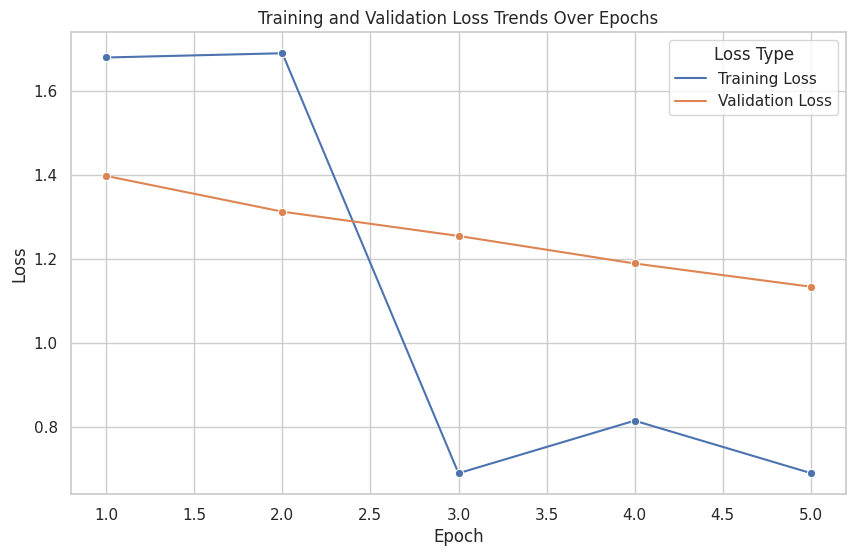

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data from CSV or Excel
df = pd.read_csv('losses_data.csv')

# Plotting the training and validation loss trends over epochs
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df.melt('Epoch', var_name='Loss Type', value_name='Loss'), x='Epoch', y='Loss', hue='Loss Type', marker='o')
plt.title('Training and Validation Loss Trends Over Epochs')
plt.show()


In [ ]:
# Specifying the save path for the model after training task
save_path = "/content/drive/MyDrive/MyModelFolder"

# Saving the model
model.save_pretrained(save_path)

# Saving the tokenizer
tokenizer.save_pretrained(save_path)


('/content/drive/MyDrive/MyModelFolder/tokenizer_config.json',
 '/content/drive/MyDrive/MyModelFolder/special_tokens_map.json',
 '/content/drive/MyDrive/MyModelFolder/vocab.txt',
 '/content/drive/MyDrive/MyModelFolder/added_tokens.json')